# Exploratory Data Analysis

## Lyrics Analysis

## Considered lyrics analysis techniques:

- Frequent words 
  - Might produce too many features
  - Might miss the "essence of the song"

- Emotions/Sentiments - Emotional features
  - Using VADER model on each sentence. 
    - Only has three categories: positive, negative, neutral. Also, difficult to separate lyrics into full sentences.
  - Using VADER model on full songs with custom lexicon
    - This is called knowledge-based Sentiment Analysis. In order to improve it, maybe we can it can use it on several songs in order to label them, and then train a neural network with this labeled data to get deeper and more sophisticated sentiment on all songs (aka combine the knowledge based with a statistical)

Document Clustering using Topic Model:
- LDA - <https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21>
  - https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
- LSA - <https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python>:
  - https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

In [67]:
import nltk
import matplotlib.pyplot as plt

all_lyrics_raw = ' '.join(all_lyrics_series.values)

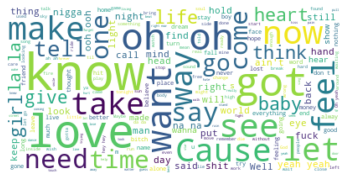

In [68]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=60, background_color = 'white').generate(all_lyrics_raw)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

### Emotion Analysis
Just as in any type of art, music is driven by emotions. Music allows writers, composers and producers to express their emotions through melodies, verses and choruses. It is also what makes listeners like/dislike certain music and feel attached to/detached from it - which is what interests us in this project.

In some songs, lyrics may give us a better clue about their tone and feelings than their melodies, so we theorize that emotion analysis of lyrics can help us predict which songs each user likes.

We could not find any dataset of songs and their emotional values, and we are not planning to manually construct it by ourselves. Therefore, we'll need to find a dataset that can help us score our songs.

Several datasets were considered for this part but dismissed:
Emotions dataset for NLP (from Kaggle), Text Emotion by CrowdFlower, ISEAR, Emotion Intensity in Tweets from the WASSA 2017 and GoEmotions.
These datasets all rely on sentences structure, which is uncovenient for lyrics analysis (it is very hard and sometimes impossible to break a song into logical sentences), only give a flat label for each example without a numeric intensity value, and also some of them are based on social media-typed slang, style and symbols, which is usually very different from the prosaic style of songs.

Instead, we will use the Rule-based sentiment analysis approach - score lyrics on word basis, using a given dictionary/lexicon and language rules.

The dataset we found most suitable for our purpose was the NRC Word-Emotion Association Lexicon suite, and specifically the Emotion Intensity Lexicon in it - A dictionary/lexicon of words with their emotion and intensity numeric value.

In the Emotion Analysis part, we give each song **eight** intensity scores for each of the following basic emotions found in our emotions lexicon dataset:
* anger
* anticipation
* disgust
* fear
* joy
* sadness
* surprise
* trust

These scores are given using **VADER**. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool. But we'll get to it later...

First, let's load all the lexicons:

In [355]:
# Load the required datasets

lexicons_by_emotion_path = 'data/NRC/OneFilePerEmotion/{}-scores.txt'
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

emotions_lexicons = {emot: dict() for emot in emotions}

def load_emotion_lex(emotion):
    with open(lexicons_by_emotion_path.format(emotion), 'r') as lexicon_file:
        for line in lexicon_file:
            word, intensity = line.split()
            emotions_lexicons[emotion][word] = float(intensity)

def dump_emotion_lex(emotion):
    with open(lexicons_by_emotion_path.format(emotion), 'w') as lexicon_file:
        lexicon_file.writelines([f'{word}\t{intensity}\n' for word, intensity in emotions_lexicons[emotion].items()])

for emotion in emotions:
    load_emotion_lex(emotion)

For example: the first (and strongest) entries of the 'joy' lexicon look like:

In [370]:
list(emotions_lexicons['joy'].items())[:8]

[('happiest', 0.986),
 ('happiness', 0.984),
 ('bliss', 0.971),
 ('celebrating', 0.97),
 ('jubilant', 0.969),
 ('ecstatic', 0.954),
 ('elation', 0.944),
 ('beaming', 0.938)]

We want to make sure the emotions lexicons match our lyrics data and does not miss out any important words. We can't possibly cover every single word that appears in any song, but we'll take the most common ones.

In [3]:
import nltk
from string import punctuation
import spacy.lang.en # found to be more extensive stopwords collection than nltk
import spacy.lang.fr
import spacy.lang.es
STOP_WORDS = spacy.lang.en.STOP_WORDS.union(spacy.lang.fr.STOP_WORDS, spacy.lang.es.STOP_WORDS)

all_words = nltk.tokenize.word_tokenize(all_lyrics_raw)
# Build FreqDist for all words found in lyrics, excluding stopwords and punctuation
lyrics_freq_dist = nltk.FreqDist(w.lower() for w in all_words if w.lower() not in STOP_WORDS and w not in punctuation)

Out of the (500) most common words in lyrics, we will build a list of all assumed sentimental words which are not present in the emotions lexicons. Since most words are not sentimental, we will only add words that are also present in VADER's lexicon, which contains about 7,000 sentimental words.

In [70]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

VADER_SCALE = 4
def_vader_analyzer = SentimentIntensityAnalyzer()

nrc_path = 'data/NRC/NRC-Emotion-Intensity-Lexicon-v1.txt'

with open(nrc_path, 'r') as lexicon_file:
    lexicon = {line.partition('\t')[0] for line in lexicon_file}

# Find all sentimenatal words that are very common in lyrics (top 500) but missing in our lexicon
missing_words = []
for idx, w in enumerate(lyrics_freq_dist.most_common(500)):
    # we assume that if a word is sentimental, it should appear in VADER default lexicon
    sentiment = def_vader_analyzer.lexicon.get(w[0])
    if sentiment and w[0] not in lexicon:
        missing_words.append((w[0], idx, sentiment))

print(f'There are {len(missing_words)} missing words:\nFORMAT:(<word>, <freq>, <sentiment>)')
print(missing_words)

There are 50 missing words:
FORMAT:(<word>, <freq>, <sentiment>)
[('yeah', 5, 1.2), ('want', 10, 0.3), ('fuck', 38, -2.5), ('better', 50, 1.9), ('niggas', 53, -1.4), ('hard', 75, -0.4), ('play', 88, 1.4), ('wrong', 104, -2.1), ('hand', 117, 2.2), ('best', 122, 3.2), ('alright', 123, 1.0), ('care', 127, 2.2), ('yes', 133, 1.7), ('wish', 142, 1.7), ('ass', 147, -2.5), ('shake', 181, -0.7), ('low', 187, -1.1), ('forget', 188, -0.9), ('bitches', 190, -2.9), ('drop', 212, -1.1), ('sure', 213, 1.3), ('dead', 220, -3.3), ('fine', 228, 0.8), ('amor', 231, 3.0), ('okay', 250, 0.9), ('easy', 252, 1.9), ('cool', 276, 1.3), ('straight', 281, 0.9), ('nah', 315, -0.4), ('cut', 317, -1.1), ('sorry', 334, -0.3), ('tired', 346, -1.9), ('tears', 347, -0.9), ('woo', 356, 2.1), ('lies', 365, -1.8), ('worth', 393, 0.9), ('great', 398, 3.1), ('dick', 406, -2.3), ('nice', 418, 1.8), ('bright', 428, 1.9), ('won', 437, 2.7), ('playing', 438, 0.8), ('rich', 445, 2.6), ('stuck', 462, -1.0), ('fucked', 463, -3.4)

Not too bad. We'll manually add the important ones to the lexicon's files:
[Note: full Lemmatizing and Stemming before analyzing the songs are not needed and should not be done, since most of the words' forms are already in the lexicon, with a distinct value for each different form]

In [81]:
# Add missing words to their respective emotion group
missing_emotions_dict = {
    # If '0' intensity value is given, it is automatically calculated from VADER lecixon (/4)
    # If '<word>' intensity value is given, it is given the same intensity as in <word>
    'joy': {'better': 0, 'best': 0, 'loves': 'love', 'alright': 0, 'care': 0.75,
        'shake': 0.5, 'fine': 0, 'okay': 0, 'easy': 0.125, 'cool': 0, 'great': 0, 'nice': 0, 'bright': 0, 'won': 0, 'rich': 0.4, 'thank': 0},
    'anger': {'fuck': 0, 'wrong': 0, 'hard': 0, 'ass': 0, 'forget': 0, 'bitches': 0, 'dick': 0, 'dead': 'death',
         'cut': 0, 'fucked': 0, 'lies': 'lie', 'stuck': 0, 'trouble': 0.1},
    'sadness': {'hard': 0, 'low': 0, 'forget': 0, 'dead': 'death', 'heartbroken': 0.781, 'sorry': 0, 'tired': 0.25, 'tears': 0.6,
         'lies': 'lie', 'stuck': 0.5, 'trouble': 0.15},
    'disgust': {'ass': 0.7, 'bitches': 0, 'dead': 'death', 'cut': 0, 
         'fucked': 0, 'lies': 'lie'},
    'fear': {'hard': 0, 'forget': 0, 'dead': 'death', 'cut': 0.1, 'stuck': 0.55, 'fucked': 0.2, 'trouble': 0},
    'surprise': {'better': 0, 'dead': 'death', 'wrong': 0, 'easy': 0, 'hard': 0, 'great': 0, 'nice': 0,
         'won': 0},
    'trust': {'loves': 'love', 'care': 0, 'sure': 0, 'fine': 0, 'thank': 0, 'believe': 0.7},
    'anticipation': {'alright': 0, 'dead': 'death', 'cool': 0, 'great': 0, 'bright': 0, 'rich': 0}
}

for emotion, new_words in missing_emotions_dict.items():
     load_emotion_lex(emotion)
     for word, intensity in new_words.items():
          if type(intensity) == str:
               intensity = emotions_lexicons[emotion][intensity]
          elif intensity == 0:
               intensity = def_vader_analyzer.lexicon.get(word) / VADER_SCALE
          emotions_lexicons[emotion][word] = abs(float(intensity))
     dump_emotion_lex(emotion)

As stated before, VADER module contains a default lexicon of words and their sentiments, with which it analyzes texts and gives them intensity positive, negative and neutral scores in scale of 0.0-1.0. However, this lexicon only has binary sentiments - positive and negative (neutral means none of them), otherwise we could just use plain VADER.

Instead, we will use VADER with our emotions lexicons in the following way:
* For sadness and joy, we can combine both lexicons, since they are exact opposites, unlike other emotions. We would have a single analyzer model for both feelings: Positive equals joy and negative equals sadness. Lack of joy means sadness and vice-versa.
* For all other emotions, we would have one analyzer model for each one, using only the 'positive' value (the positive value would mean intensity of that specific emotion).

Since VADER is a generic model, by replacing its lexicon with emotions lexicons we can (hopefully) accurately identify songs' general emotions. Emotions intensities are determined not only by the presence and frequency of words from the corresponding lexicon in the text, but also by the presence of booster/negation words in their context (such as very, extemely, barely, not, etc.)

Let's copy our lexicons to the VADER's directory and create analyzers out of them.

In [114]:
import shutil
import os
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_dir = os.path.dirname(vaderSentiment.__file__)
emotions_vader_analyzers = {}

# Copy all lexicons to the VADER module's directory
for emot in emotions:
    load_emotion_lex(emot)
    # Intensities of words in our lexicon are in the range 0.0-1.0, VADER values are in range 0.0-4.0
    # So we multiply every intensity value by 4 before copying the lexicons
    emotions_lexicons[emot].update((x, y*VADER_SCALE) for x, y in emotions_lexicons[emot].items())
    if emot != 'sadness' and emot != 'joy':
        dump_emotion_lex(emot)
        emotion_lexicon_filename = os.path.basename(lexicons_by_emotion_path.format(emot))
        shutil.copyfile(lexicons_by_emotion_path.format(emot), os.path.join(vader_dir, emotion_lexicon_filename))
        emotions_vader_analyzers[emot] = SentimentIntensityAnalyzer(emotion_lexicon_filename)

# Create a combined lexicon of joy and sadness
# by adding sadness words with (-1)*intensity
for word, intensity in emotions_lexicons['sadness'].items():
    if word not in emotions_lexicons['joy'] or emotions_lexicons['joy'][word] < intensity:
        emotions_lexicons['joy'][word] = -intensity
dump_emotion_lex('joy')
emotion_lexicon_filename = os.path.basename(lexicons_by_emotion_path.format('joy'))
shutil.copyfile(lexicons_by_emotion_path.format('joy'), os.path.join(vader_dir, emotion_lexicon_filename))
emotions_vader_analyzers['joy'] = SentimentIntensityAnalyzer(emotion_lexicon_filename)

Let's take a look at two songs for example - one very joyful, and the other very sad, according to one of our analyzers.

Note: Whenever we analyze a song, we first of all remove all stopwords, EXCEPT those that are used by VADER for the analysis (negators and boosters).

In [1466]:
import spacy.lang.en
from vaderSentiment.vaderSentiment import negated, BOOSTER_DICT
import re

unnecessary_stopwords = {word for word in spacy.lang.en.STOP_WORDS if not negated([word]) and word not in BOOSTER_DICT.keys()}

def trim_text(text):
    # Make the popular n' suffix into ng and remove unnecessary words
    text_words = [re.sub(r"n'$", "ng", w) 
        for w in text.split() if re.match(r'[a-zA-Z’‘\']*', w.lower()).group() not in unnecessary_stopwords]
    return ' '.join(text_words)

def analyze_song(lyrics, emotion):
    # sadness value is the negative value of 'joy' analysis
    if emotion == 'sadness':
        emotion, sentiment = 'joy', 'neg'
    else:
        sentiment = 'pos'
    return emotions_vader_analyzers[emotion].polarity_scores(trim_text(lyrics))[sentiment]

In [88]:
import spacy.lang.en
from vaderSentiment.vaderSentiment import negated, BOOSTER_DICT
from random import sample
import re

unnecessary_stopwords = {word for word in spacy.lang.en.STOP_WORDS if not negated([word]) and word not in BOOSTER_DICT.keys()}

def trim_text(text):
    text_words = [re.sub(r"n'$", "ng", w) 
        for w in text.split() if re.match(r'[a-zA-Z’‘\']*', w.lower()).group() not in unnecessary_stopwords]
    return ' '.join(text_words)

def analyze_song(lyrics, emotion):
    # sadness value is the negative value of 'joy' analysis
    if emotion == 'sadness':
        emotion, sentiment = 'joy', 'neg'
    else:
        sentiment = 'pos'
    return emotions_vader_analyzers[emotion].polarity_scores(trim_text(lyrics))[sentiment]

def find_max_song(N, emotion):
    max_song = ('', 0.0)
    lyrics_list = sample([x for x in all_lyrics_series if len(x) > 600], N)
    for lyrics in lyrics_list:
        val = analyze_song(lyrics, emotion)
        if val > max_song[1]:
            max_song = (lyrics, val)

    # Print all analyzers results for it
    for emotion, analyzer in emotions_vader_analyzers.items():
        print(f'{emotion}: {analyzer.polarity_scores(trim_text(max_song[0]))}')

    return max_song[0]

# Find most joyful song in randomly selected 500 songs
find_max_song(500, 'joy')

anger: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
anticipation: {'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.9851}
disgust: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
fear: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
surprise: {'neg': 0.0, 'neu': 0.669, 'pos': 0.331, 'compound': 0.9692}
trust: {'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'compound': 0.9962}
joy: {'neg': 0.014, 'neu': 0.236, 'pos': 0.749, 'compound': 0.999}


"How Sweet It Is\nNeeded the shelter from somebody's arms\nAnd there you were\nNeeded who share my ups and downs\nAnd there you were\nWith sweet love and devotion\nDeeply touching my emotion\nI wanna stop and thank you, baby\nJust wanna to stop and thank you\nHow sweet it is to be loved by you\nHow sweet it is to be loved by you\nClose my eyes and I wonder where would I be\nWithout you in my life\nEverything I did was such a bore\nEverywhere I've been it seems I had been there before\nBut you brighten up all of my days\nWith love so sweet in so many ways\nI wanna stop and thank you, baby\nI just wanna to stop and thank you\nHow sweet it is to be loved by you\nHow sweet it is to be loved by you\nYou were better for me than I was for myself\nFor me, there's you and there's nobody else\nI wanna stop and thank you, baby\nJust wanna to stop and thank you\nHow sweet it is to be loved by you\nHow sweet it is to be loved by you\nHow sweet it is to be loved by you\nHow sweet it is to be loved b

In [89]:
# Find saddest song in randomly selected 500 songs
find_max_song(500, 'sadness')

anger: {'neg': 0.0, 'neu': 0.978, 'pos': 0.022, 'compound': 0.1027}
anticipation: {'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'compound': 0.8828}
disgust: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
fear: {'neg': 0.0, 'neu': 0.978, 'pos': 0.022, 'compound': 0.1027}
surprise: {'neg': 0.0, 'neu': 0.918, 'pos': 0.082, 'compound': 0.5013}
trust: {'neg': 0.041, 'neu': 0.703, 'pos': 0.256, 'compound': 0.9592}
joy: {'neg': 0.522, 'neu': 0.311, 'pos': 0.166, 'compound': -0.9934}


'Crying\nI was alright for a while\nI could smile for a while\nBut I saw you last night\nYou held my hand so tight\nAs you stopped to say, "Hello"\n\nOh, you wished me well\nYou couldn\'t tell\nThat I\'d been crying over you\nCrying over you\nWhen you said, "So long"\nLeft me standing all alone\nAlone and crying, crying\nCrying, crying\n\nIt\'s hard to understand\nBut the touch of your hand\nCan start me crying\n\nI thought that I was over you\nBut it\'s true, so true\nI love you even more\nThan I did before\nBut darling, what can I do?\nFor you don\'t love me\nAnd I\'ll always be\nCrying over you\nCrying over you\nYes, now you\'re gone\nAnd from this moment on\nI\'ll be crying, crying\nCrying, crying\n\nYeah, I\'m crying, crying\nOver you'

We can now analyze and score all songs.

In [107]:
import pandas as pd

all_songs_emotions = pd.DataFrame({emotion: [analyze_song(lyrics, emotion) for lyrics in all_lyrics_series]
                                  for emotion in emotions}, 
                                  index=all_lyrics_series.keys())
all_songs_emotions.to_csv('data/songs_emotions.csv')
all_songs_emotions.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0UaMYEvWZi0ZqiDOoHU3YI,0.124,0.046,0.058,0.102,0.132,0.075,0.092,0.081
6I9VzXrHxO9rA9A5euc8Ak,0.098,0.084,0.204,0.177,0.188,0.100,0.000,0.089
0WqIKmW4BTrj3eJFmnCKMv,0.238,0.078,0.036,0.247,0.189,0.196,0.043,0.148
1AWQoqb9bSvzTjaLralEkT,0.074,0.082,0.069,0.031,0.237,0.000,0.057,0.183
1lzr43nnXAijIGYnCT8M8H,0.034,0.066,0.009,0.075,0.059,0.065,0.033,0.075


array([[<AxesSubplot:title={'center':'anger'}>,
        <AxesSubplot:title={'center':'anticipation'}>],
       [<AxesSubplot:title={'center':'disgust'}>,
        <AxesSubplot:title={'center':'fear'}>],
       [<AxesSubplot:title={'center':'joy'}>,
        <AxesSubplot:title={'center':'sadness'}>],
       [<AxesSubplot:title={'center':'surprise'}>,
        <AxesSubplot:title={'center':'trust'}>]], dtype=object)

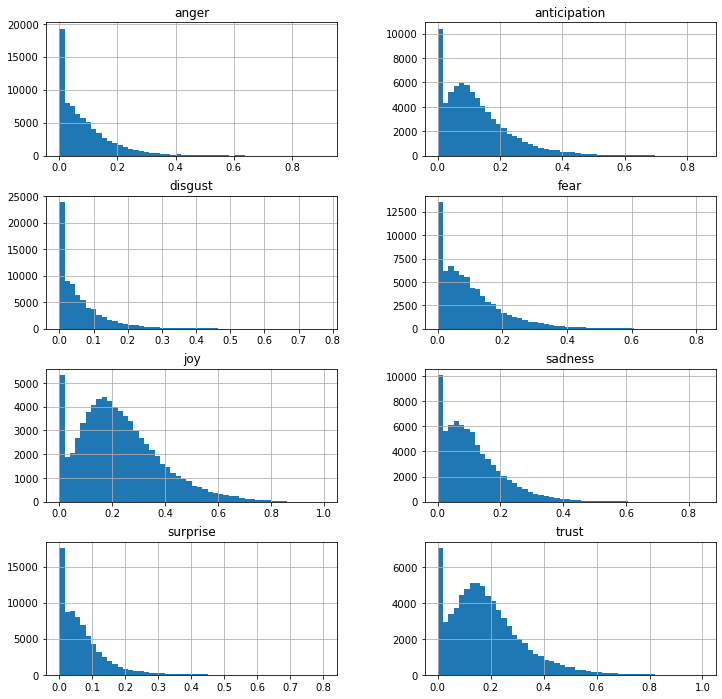

In [238]:
import pandas as pd

all_songs_emotions = pd.read_csv('data/songs_emotions.csv', index_col=0)

pd.DataFrame(all_songs_emotions).hist(layout=(4,2), figsize=[12, 12], bins=50)

Let's visualize all features, one pair at a time, to find out how much (if any) they are correlated:

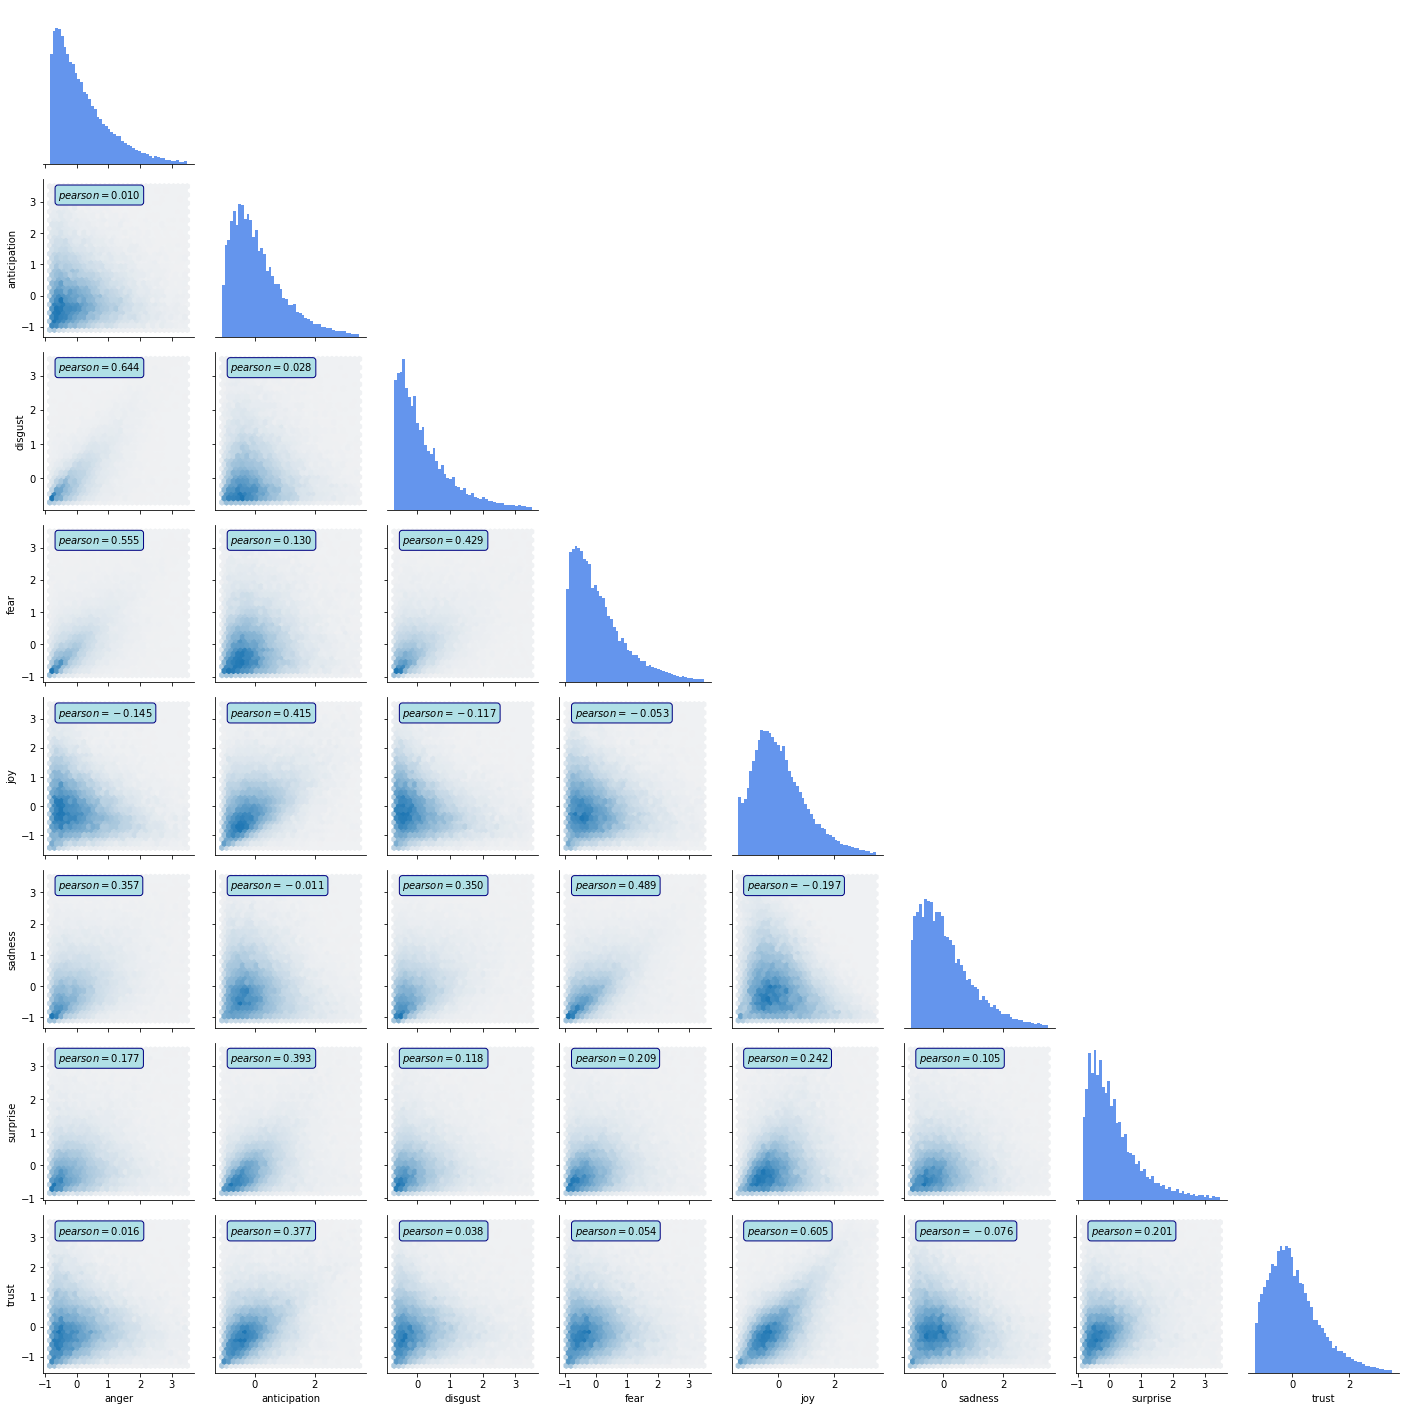

In [340]:
import seaborn as sns
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def hide_current_axis(*args, **kwargs):
    plt.gca().set_visible(False)

def jointplot_hex(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    xy_df = pd.concat([x, y], axis=1)
    nonzero_cells_filter = (xy_df > 0.007)
    xy_df = pd.DataFrame(zscore(xy_df), columns=[x.name, y.name], index=x.index)
    outliers_filter = nonzero_cells_filter & (np.abs(xy_df) < 3.5)
    xy_df = xy_df[outliers_filter.iloc[:,0] & outliers_filter.iloc[:,1]]

    pearson = stats.pearsonr(xy_df.iloc[:,0], xy_df.iloc[:,1])[0]

    ax = plt.gca()
    plt.hexbin(xy_df.iloc[:,0], xy_df.iloc[:,1], cmap=cmap, gridsize=30, **kwargs)
    plt.annotate(f'$pearson = {pearson:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

def filtered_hist(x, **kwargs):
    nonzero_cells_filter = (x > 0.007)
    x = pd.Series(zscore(x), name=x.name, index=x.index)
    outliers_filter = nonzero_cells_filter & (np.abs(x) < 3.5)
    x = x[outliers_filter]
    plt.hist(x=x, bins=50, **kwargs)

all_songs_emotions = pd.read_csv('data/songs_emotions.csv', index_col=0)

# For our purpose, an outlier is a value that is more than 3 standard deviations from the mean
g = sns.PairGrid(data=all_songs_emotions, corner=True)
g.map_lower(jointplot_hex)
g.map_upper(hide_current_axis)
g.map_diag(filtered_hist, color='cornflowerblue')


We can see a moderate correlation in two pairs of features:
* anger-disgust - 0.644
* joy-trust - 0.605

We may consider omitting one feature out of each pair as a dimensionality reduction

TODO: Make sure that scores are not biased towards shorter songs.

#### Limitations

As large and exhaustive as our lexicons are, the entire English vocabulary, even just the relatively common and generally used part of it is much larger. Many emotional words will not be detected when using the lexicons alone. Many other words might have multiple meanings and be misunderstood, and others were written differently their dictionary form (like cryin' instead of crying).

Moreover, VADER analyzer is only based on scoring unigrams and some bigrams: single sentimental words and sometimes negatives/boosters that go along with them and increase/reduce/negate their intensity. It might completely ignore phrases and any other meaningful word combinations.

Perhaps we can combine deep learning with our analyzers in order to tackle these issues.

### Topic Model

A topic model is a generative model that intends to discover underlying topics in a collection of documents and each documents’ assumed closeness to this topic. A popular and well-established Topic Modeling algorithm is Latent Dirichlet Allocation (LDA), which is a probabilistic generative model that builds on the assumption that every document in a literature corpus is a mixture of latent topics and each of these topics themselves is a probability distribution over words.

By using the topic model on our songs lyrics, we may be able to identify common topics/themes and cluster songs based on these topics.

We'll do some necessary preprocessing first.

#### Filtering non-English songs
* [A topic model is suited for a single language]

In [2215]:
from langdetect import detect_langs

all_lyrics_lang = pd.Series({tr_id: detect_langs(lyric)[0] for tr_id, lyric in all_lyrics_series.items()})
all_lyrics_series = all_lyrics_series[[l.lang == 'en' and l.prob >=0.95 for l in all_lyrics_lang]]
all_lyrics_series.to_pickle('all_lyrics_series.pkl')

#### Lyric Tokenization

In [2129]:
from nltk.tokenize import RegexpTokenizer

# Filter out numbers and words shorter than 3 characters
tokenizer = RegexpTokenizer(r'[a-zA-Z’‘\']{3,}')
# replace the popular "n'" suffixes with "ng" and "'cause" with "because" for better words recognition
all_lyrics_tokenized = [[re.sub(r"n'$", "ng", re.sub(r"^'cause$", "because", re.sub(r'[‘’]', "'", token))) 
        for token in tokenizer.tokenize(lyric.lower())] 
    for lyric in all_lyrics_series]

#### Token Lemmatization and removing Stop Words
* Lemmatization package was chosen using an efficiency comparison and the comparison done [here](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)

In [2134]:
import treetaggerwrapper as ttpw
import spacy.lang.en
from vaderSentiment.vaderSentiment import NEGATE, BOOSTER_DICT
import pandas as pd

tagger = ttpw.TreeTagger(TAGLANG='en')
# We add some more special stopwords, common in songs
lyrics_stop_words = ['ooh','yeah', 'yes', 'hey', 'whoa' 'woah', 'ohh', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah', 'til', 'till']

# This time we don't need negation and booster words
topics_stopwords = spacy.lang.en.STOP_WORDS.union(NEGATE, BOOSTER_DICT.keys(), lyrics_stop_words)

for idx, song in enumerate(all_lyrics_tokenized):
    all_lyrics_tokenized[idx] = [token for token in [t.split('\t')[-1] for t in tagger.tag_text(song)] 
        if token not in topics_stopwords and len(token) > 2] 

pd.Series(all_lyrics_tokenized).to_pickle('all_lyrics_tokenized.pkl')

#### Dictionary Creation and occurrence-based Filtering

In order to perform Latent Dirichlet Allocation, we use the popular and well-established Python library gensim, which requires a dictionary representation of the documents. This means all tokens are mapped to a unique ID, which reduces the overall dimensionality of a literature corpus. In addition, we filter out tokens that occur in less than 60 songs, as well as tokens that occur in more than 85% of songs.

In [2]:
from gensim.corpora import Dictionary

dictionary = Dictionary(all_lyrics_tokenized)
dictionary.filter_extremes(no_below = 60, no_above = 0.85)
dictionary.save('lyrics_for_topics_dict.dct')
dictionary.save_as_text('lyrics_for_topics_dict.txt')

#### Bag-of-Words and Index to Dictionary Conversion

Each song (as of now a list of tokens) is converted into the bag-of-words format, which only stores the unique token ID and its count for each song.

In [10]:
gensim_corpus = [dictionary.doc2bow(song) for song in all_lyrics_tokenized]

#### Determining the number of topics

Another extra step needs to be taken to optimize results and that is identifying an optimum amount of topics. 

LDA model can cluster our songs into topics, but it requires a number of topics parameter - k. If k is too small, our topics will be too general, contain too many words, and the songs that share them will not actually be similar. However, giving a k which is too large will yield fractions of topics, repetition of certain words in many of them, and not enough similar songs for each song.

The mathematical measure of how good a topic is is called Topic Coherence. it measures the degree of semantic similarity between high scoring words in the topic (detailed information [here](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)).

We will create multiple LDA models for our data, with multiple k values, compute their coherence values, and find the k which gives us the maximum value.

In [34]:
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

# lda_model_for_k = {}
def get_coherence_for_k(k):
    # generate LDA model for the tested parameter value and compute coherence for it
    # model = LdaMulticore(corpus=gensim_corpus, num_topics=k, id2word=dictionary, 
    #     alpha=a, eta=b, passes=10, iterations=400, chunksize=1000)
    model = LdaMulticore(corpus=gensim_corpus, num_topics=k, id2word=dictionary, 
        passes=10, iterations=400, chunksize=1000)
    lda_model_for_k[k] = model
    coherencemodel = CoherenceModel(model=model, texts=all_lyrics_tokenized, dictionary=dictionary, coherence='c_v')
    coherence = coherencemodel.get_coherence()
    print(f'LDA model with k={k} created with coherence={coherence}')
    return coherencemodel.get_coherence()

In [36]:
pd.Series(coherences_dict)

4     0.402882
5     0.409358
6     0.389172
7     0.410561
8     0.407175
9     0.409869
10    0.398410
11    0.395535
12    0.401565
13    0.408578
14    0.390141
15    0.404231
16    0.393772
17    0.389348
dtype: float64

<AxesSubplot:xlabel='k', ylabel='coherence'>

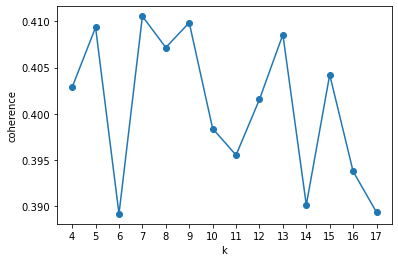

In [57]:
# import plotly.express as px
import pandas as pd

coherences = pd.Series(dtype='float64')

k_test_range = range(4, 18)
for i in k_test_range:
    if i not in coherences.keys():
        coherences.at[i] = get_coherence_for_k(i)

coherences.plot(xticks=k_test_range, xlabel='k', ylabel='coherence', marker='o')

7 seems to be our magic number.
Let's visualize the inferred topics:

In [63]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

vis_data = gensimvis.prepare(lda_model_for_k[coherences.idxmax()], gensim_corpus, dictionary)
pyLDAvis.save_html(vis_data, './Lyrics_LDA_k_'+ str(coherences.idxmax()) +'.html')
pyLDAvis.display(vis_data)

C:\Users\LiorB\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Save models to disk.
[lda_model_for_k[i].save(f"lda_models/lda_model_{i}k") for i in lda_model_for_k.keys()]
